In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import pandas as pd

import sklearn as sk
import sklearn.cluster as skc
import sklearn.decomposition as skd
import sklearn.manifold as skm
import statsmodels.tsa.stattools as stattools

from scipy import stats

from quantopian.pipeline.data import morningstar
from quantopian.pipeline.filters.morningstar import Q500US, Q1500US, Q3000US
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline

In [2]:
study_date = "2016-12-31"

## 1. Define Universe

In [3]:
# FIXME: CHANGE TO RUSSELL 3000 OR ANOTHER INDEX
universe = Q1500US()

In [4]:
universe

PrecomputedFilter(NumExprFilter(...), name='QUS___mcap_500000000__size_1500__version_3')

Link to Morning Star fundamentals Documentation https://www.quantopian.com/help/fundamentals#asset-classification

In [41]:
pipe = Pipeline(
    columns= {'Market Cap': morningstar.valuation.market_cap.latest.quantiles(5),
              'Industry': morningstar.asset_classification.morningstar_industry_group_code.latest,
              'Financial Health': morningstar.asset_classification.financial_health_grade.latest
             },
    screen= universe)

Get Result from our specified pipeline

In [42]:
res = run_pipeline(pipe, study_date, study_date)
res.index = res.index.droplevel(0)  # drop the single date from the multi-index

In [43]:
print res.shape
res.head()

(1500, 3)


,Financial Health,Industry,Market Cap
Equity(2 [ARNC]),C,10106,4
Equity(24 [AAPL]),A,31167,4
Equity(53 [ABMD]),A,20639,3
Equity(62 [ABT]),B,20639,4
Equity(67 [ADSK]),B,31165,4


In [44]:
# remove stocks in Industry "Conglomerates"
industry_code = 31055
res = res[res['Industry'] != industry_code]
print res.shape

(1499, 3)


In [45]:
# remove stocks without a Financial Health grade
res = res[res['Financial Health'] != None]
print res.shape

(1498, 3)


In [46]:
# replace the categorical data with numerical scores per the docs
res['Financial Health'] = res['Financial Health'].astype('object')
health_dict = {u'A': 0.1,
               u'B': 0.3,
               u'C': 0.7,
               u'D': 0.9,
               u'F': 1.0}
res = res.replace({'Financial Health': health_dict})

In [47]:
res.describe()

,Financial Health,Industry,Market Cap
count,1498.000000,1498.000000,1498.000000
mean,0.447397,20268.038051,3.389853
std,0.266994,9214.022203,0.647861
min,0.100000,10101.000000,2.000000
25%,0.300000,10320.000000,3.000000
50%,0.300000,20635.000000,3.000000
75%,0.700000,31054.000000,4.000000
max,1.000000,31169.000000,4.000000


## Define Horizon
We are going to work with a daily return horizon in this strategy.

In [48]:
pricing = get_pricing(
    symbols= res.index,
    fields= 'close_price',
    start_date= pd.Timestamp(study_date) - pd.DateOffset(months=24),
    end_date= pd.Timestamp(study_date)
)

pricing.shape

(505, 1498)

In [49]:
returns = pricing.pct_change()

In [50]:
# sample_tick = res.index[0].symbol
# returns[symbols(['sample_tick'])].plot();

In [51]:
# we can only work with stocks that have the full return series
returns = returns.iloc[1:,:].dropna(axis=1)

In [52]:
print returns.shape

(504, 1400)


## 2. Find Candidate Pairs
Given the pricing data and the fundamental and industry/sector data, we will first classify stocks into clusters and then, within clusters, looks for strong mean-reverting pair relationships.

### PCA Decomposition and DBSCAN Clustering

In [53]:
N_PRIN_COMPONENTS = 50
pca = skd.PCA(n_components= N_PRIN_COMPONENTS)
pca.fit(returns)

PCA(copy=True, n_components=50, whiten=False)

In [54]:
pca.components_.T.shape

(1400, 50)

We have reduced data now with the first `N_PRIN_COMPONENTS` principal component loadings. Let's add some fundamental values as well to make the model more robust.

In [55]:
X = np.hstack(
    (pca.components_.T,
     res['Market Cap'][returns.columns].values[:, np.newaxis],
     res['Financial Health'][returns.columns].values[:, np.newaxis])
)

print X.shape

(1400, 52)


In [56]:
X = sk.preprocessing.StandardScaler().fit_transform(X)
print X.shape

(1400, 52)


In [57]:
clf = skc.DBSCAN(eps=1.9, min_samples=3)
print clf

clf.fit(X)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print "\nClusters discovered: %d" % n_clusters_

clustered = clf.labels_

DBSCAN(algorithm='auto', eps=1.9, leaf_size=30, metric='euclidean',
    min_samples=3, p=None, random_state=None)

Clusters discovered: 12


In [58]:
# the initial dimensionality of the search was
ticker_count = len(returns.columns)
print "Total pairs possible in universe: %d " % (ticker_count*(ticker_count-1)/2)

Total pairs possible in universe: 979300 


In [59]:
clustered_series = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series_all = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

In [60]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print "Clusters formed: %d" % len(ticker_count_reduced)
print "Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum()

Clusters formed: 12
Pairs to evaluate: 2360


We have reduced the search space for pairs from >1mm to approximately 2,000.

### Cluster Visualization
To visualize what has happened in 2d, we can try with [T-SNE](https://distill.pub/2016/misread-tsne/). T-SNE is an algorithm for visualizing very high dimension data in 2d, created in part by Geoff Hinton. We visualize the discovered pairs to help us gain confidence that the `DBSCAN` output is sensible; i.e., we want to see that T-SNE and DBSCAN both find our clusters.

In [61]:
X_tsne = skm.TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X)

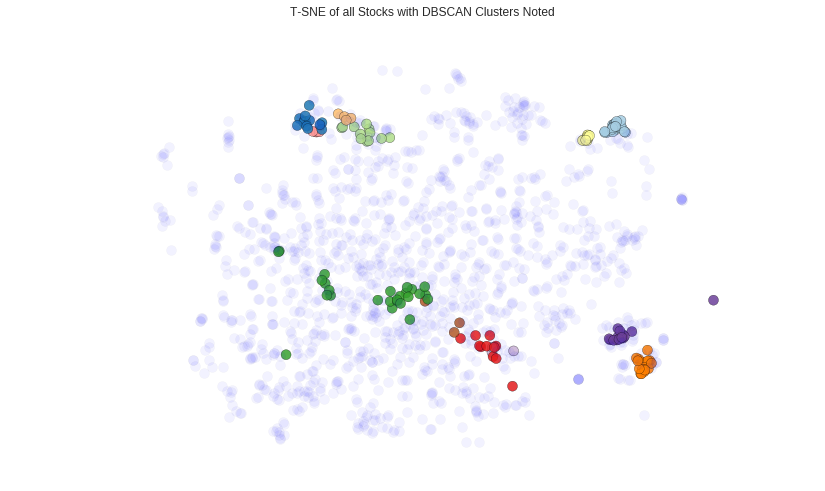

In [62]:
plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')

plt.scatter(
    X_tsne[(labels!=-1), 0],
    X_tsne[(labels!=-1), 1],
    s=100,
    alpha=0.85,
    c=labels[labels!=-1],
    cmap=cm.Paired
)

plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.05
)

plt.title('T-SNE of all Stocks with DBSCAN Clusters Noted');

We can also see how many stocks we found in each cluster and then visualize the normalized time series of the members of a handful of the smaller clusters.

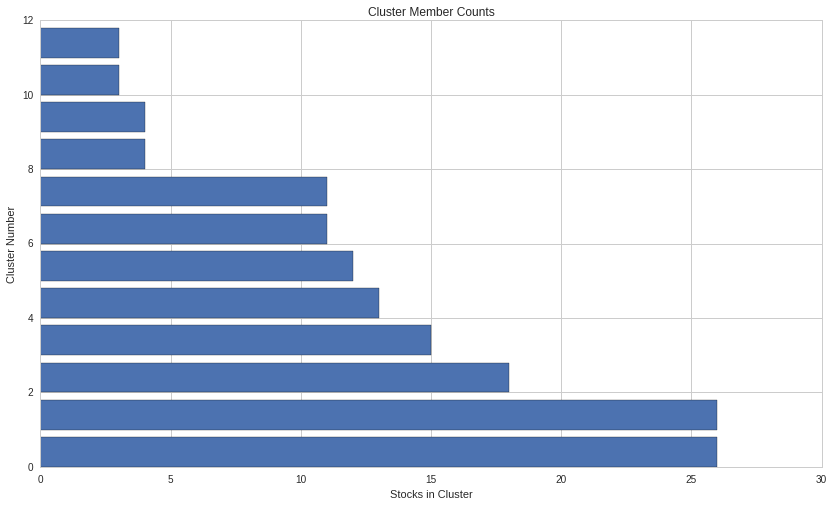

In [63]:
plt.barh(
    xrange(len(clustered_series.value_counts())),
    clustered_series.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number');

To again visualize if our clustering is doing anything sensible, let's look at a few clusters (for reproducibility, keep all random state and dates the same in this notebook).

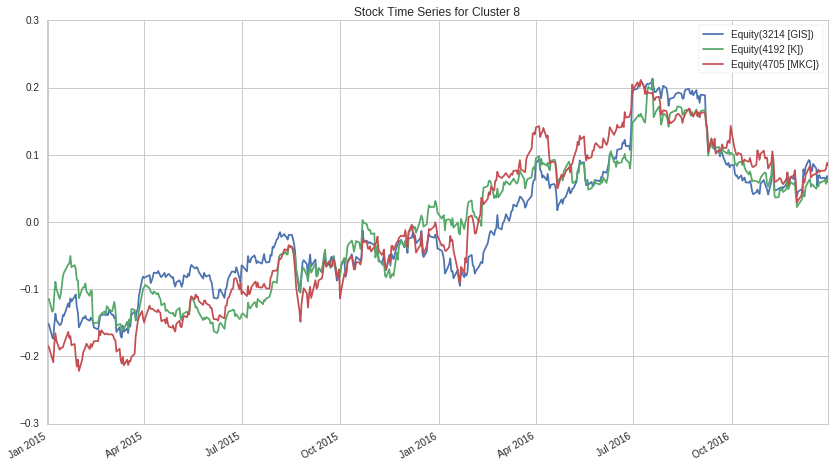

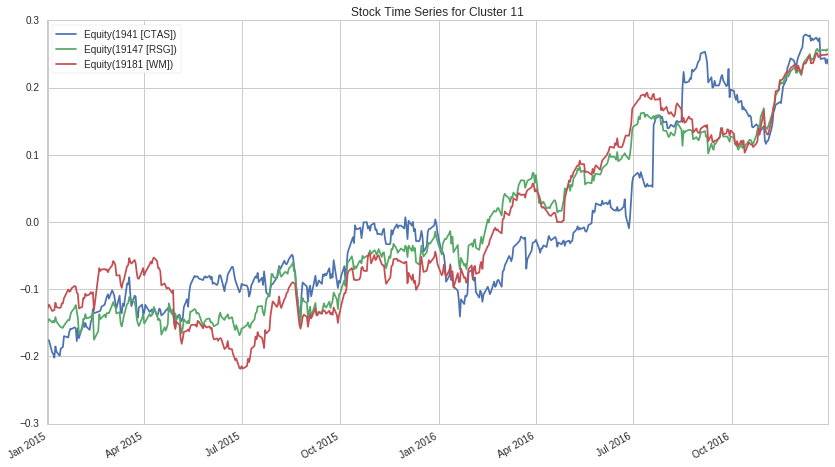

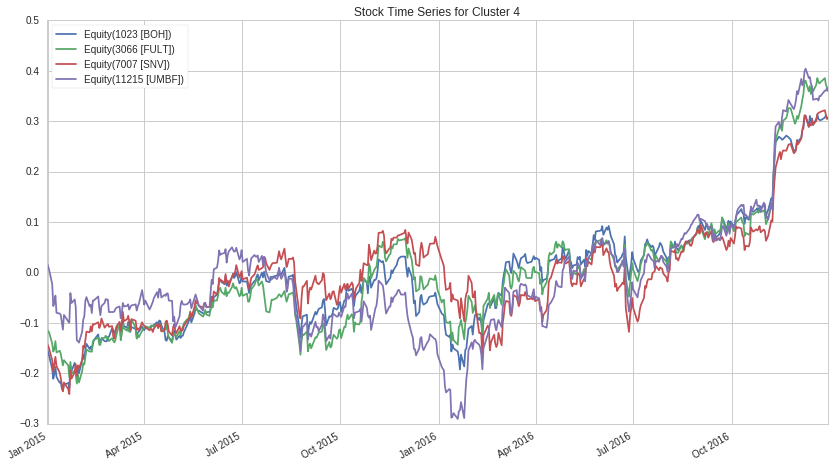

In [64]:
# get the number of stocks in each cluster
counts = clustered_series.value_counts()

# let's visualize some clusters
cluster_vis_list = list(counts[(counts<20) & (counts>1)].index)[::-1]

# plot a handful of the smallest clusters
for clust in cluster_vis_list[0:min(len(cluster_vis_list), 3)]:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(pricing[tickers].mean())
    data = np.log(pricing[tickers]).sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % clust)

We might be interested to see how a cluster looks for a particular stock. Large bank stocks share similar strict regulatory oversight and are similarly economic and interest rate sensitive. We indeed see that our clustering has found a bank stock cluster.

In [65]:
which_cluster = clustered_series.loc[symbols('JPM')]
clustered_series[clustered_series == which_cluster]

Equity(700 [BAC])      2
Equity(903 [BK])       2
Equity(1335 [C])       2
Equity(5117 [MTB])     2
Equity(5479 [NTRS])    2
Equity(5769 [PBCT])    2
Equity(7152 [STI])     2
Equity(8151 [WFC])     2
Equity(16850 [BBT])    2
Equity(20088 [GS])     2
Equity(25006 [JPM])    2
Equity(25010 [USB])    2
dtype: int64

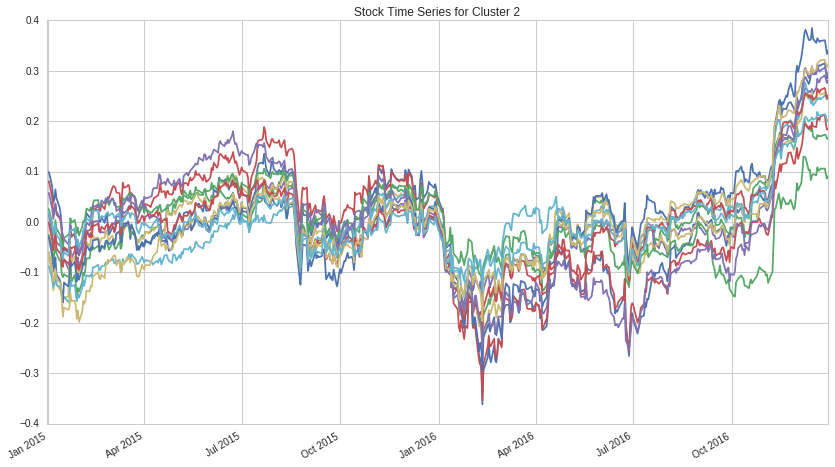

In [66]:
tickers = list(clustered_series[clustered_series==which_cluster].index)
means = np.log(pricing[tickers].mean())
data = np.log(pricing[tickers]).sub(means)
data.plot(legend=False, title="Stock Time Series for Cluster %d" % which_cluster);

Now that we have sensible clusters of common stocks, we can validate the cointegration relationships.

In [67]:
def find_cointegrated_pairs(data, significance=0.05):
    # This function is from https://www.quantopian.com/lectures/introduction-to-pairs-trading
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = stattools.coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [68]:
cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        pricing[tickers]
    )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs

In [69]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

In [70]:
pairs

[(Equity(161 [AEP]), Equity(1665 [CMS])),
 (Equity(161 [AEP]), Equity(2434 [ED])),
 (Equity(161 [AEP]), Equity(8140 [WEC])),
 (Equity(161 [AEP]), Equity(21964 [XEL])),
 (Equity(161 [AEP]), Equity(36098 [AWK])),
 (Equity(612 [ATO]), Equity(1665 [CMS])),
 (Equity(612 [ATO]), Equity(21964 [XEL])),
 (Equity(612 [ATO]), Equity(24783 [AEE])),
 (Equity(1665 [CMS]), Equity(2434 [ED])),
 (Equity(1665 [CMS]), Equity(8140 [WEC])),
 (Equity(1665 [CMS]), Equity(21964 [XEL])),
 (Equity(1665 [CMS]), Equity(24783 [AEE])),
 (Equity(1665 [CMS]), Equity(36098 [AWK])),
 (Equity(2071 [D]), Equity(2330 [DTE])),
 (Equity(2071 [D]), Equity(5792 [PCG])),
 (Equity(2071 [D]), Equity(6090 [PNW])),
 (Equity(2071 [D]), Equity(8265 [WR])),
 (Equity(2071 [D]), Equity(14372 [EIX])),
 (Equity(2330 [DTE]), Equity(6090 [PNW])),
 (Equity(2330 [DTE]), Equity(8265 [WR])),
 (Equity(2434 [ED]), Equity(8140 [WEC])),
 (Equity(2434 [ED]), Equity(21964 [XEL])),
 (Equity(2968 [NEE]), Equity(5792 [PCG])),
 (Equity(2968 [NEE]), Equi

In [71]:
print "We found %d pairs." % len(pairs)

We found 103 pairs.


In [72]:
print "In those pairs, there are %d unique tickers." % len(np.unique(pairs))

In those pairs, there are 86 unique tickers.


### Pair Visualization
Lastly, for the pairs we found and validated, let's visualize them in 2d space with T-SNE again.

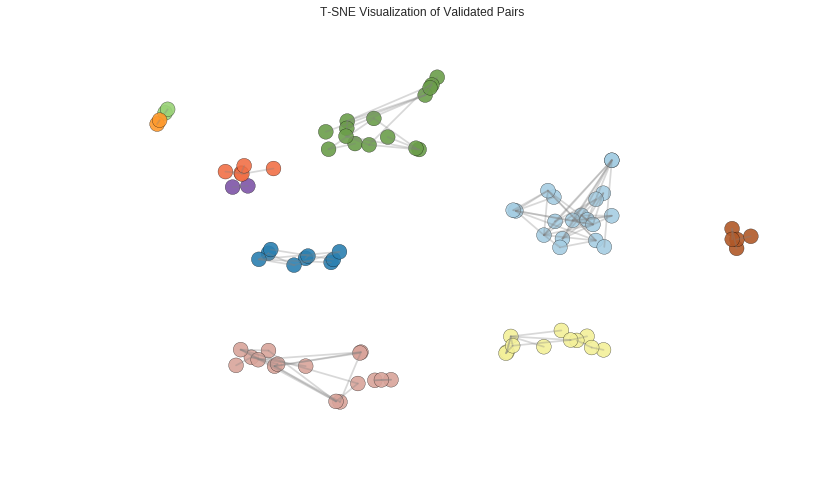

In [73]:
stocks = np.unique(pairs)
X_df = pd.DataFrame(index=returns.T.index, data=X)
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_df.loc[stocks]

X_tsne = skm.TSNE(learning_rate=50, perplexity=3, random_state=1337).fit_transform(X_pairs)

plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')
for pair in pairs:
    ticker1 = pair[0].symbol
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]

    ticker2 = pair[0].symbol
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
      
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='gray');
        
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=220, alpha=0.9, c=[in_pairs_series.values], cmap=cm.Paired)
plt.title('T-SNE Visualization of Validated Pairs');
